# Hyperparameter tuning

now it's time to tune our models by changing hyperparameters

## import libs

In [1]:
import re
import string
from abc import ABC

from nltk.corpus import stopwords

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle
import warnings

warnings.filterwarnings('ignore')

## import models, input providers and other codes

In [2]:
from input_providers import *
from metrics import MetricsCalculator
from models import *
from workflow import TrainValidationWorkflow
from report import report

## train, validation and test data sets split

In [3]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/train.csv')
random_state_seed = 22
df_train_validation, df_test = train_test_split(df, test_size=0.2, random_state=random_state_seed)
df_train, df_validation = train_test_split(df_train_validation, test_size=0.25, random_state=random_state_seed)

In [4]:
input_providers = [InputProvider1(), InputProvider2(), InputProvider3(), InputProvider4(), InputProvider5()]

## hyperparameter tuning of Logistic regression model 
the important hyperparameters to tune for `sklearn.linear_model.LogisticRegression` include:
- `C`: inverse of the regularization strength
- `solver`
- `max_iter`

#### optimize inverse of the regularization strength

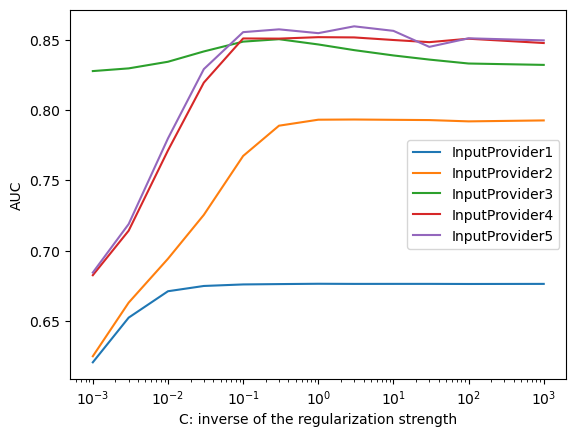

In [26]:
performance = dict()
c_range = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 1000]

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for c in c_range:
        metrics = TrainValidationWorkflow(
            model=LogisticRegressionModel(C=c, random_state=random_state_seed),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

for key, value in performance.items():
    plt.semilogx(c_range, value, label=key)
    plt.xlabel('C: inverse of the regularization strength')
    plt.ylabel('AUC')
    plt.legend()

c=0.1 seems to be a good number for all input providers

#### optimize solver
sklearn logistic regression has various solvers:
1. newton-cg: This solver uses a modified Newton's method to solve the optimization problem. It is recommended for datasets with a small number of samples and features.
2. lbfgs: This solver uses the Limited-memory Broyden-Fletcher-Goldfarb-Shanno algorithm to solve the optimization problem. It is recommended for datasets with a small number of samples and features.
3. liblinear: This solver uses a coordinate descent algorithm to solve the optimization problem. **It is recommended for datasets with a large number of samples and features.**
4. sag: This solver uses a stochastic average gradient descent algorithm to solve the optimization problem. **It is recommended for datasets with a large number of samples and features.**
5. saga: This solver uses a variant of the stochastic average gradient descent algorithm to solve the optimization problem. **It is recommended for datasets with a large number of samples and features.**

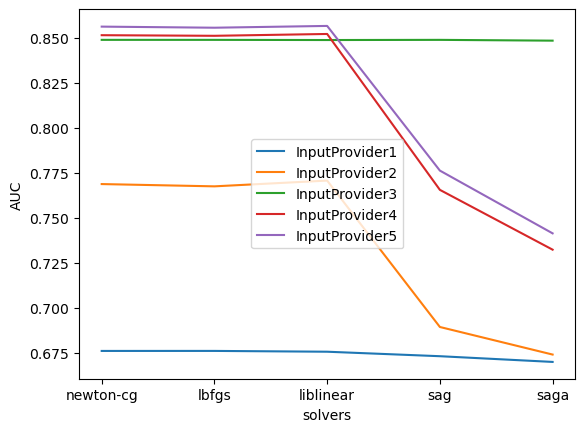

In [27]:
performance = dict()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for solver in solvers:
        metrics = TrainValidationWorkflow(
            model=LogisticRegressionModel(C=0.1, solver=solver, random_state=random_state_seed),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

for key, value in performance.items():
    plt.plot(solvers, value, label=key)
    plt.xlabel('solvers')
    plt.ylabel('AUC')
    plt.legend()

liblinear seems to be a good model here

## optimize max_iter

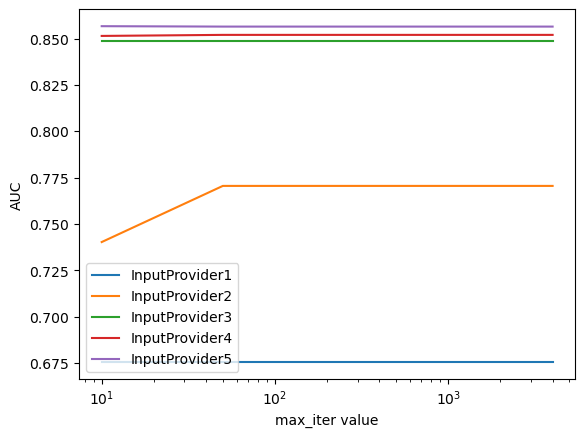

In [29]:
performance = dict()
max_iterations = [10, 50, 100, 200, 500, 1000, 2000, 4000]

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for max_iter in max_iterations:
        metrics = TrainValidationWorkflow(
            model=LogisticRegressionModel(C=0.1, solver='liblinear', max_iter=max_iter, random_state=random_state_seed),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

for key, value in performance.items():
    plt.semilogx(max_iterations, value, label=key)
    plt.xlabel('max_iter value')
    plt.ylabel('AUC')
    plt.legend()

we would use the default value for max_iter which is 100
finally our model is this:

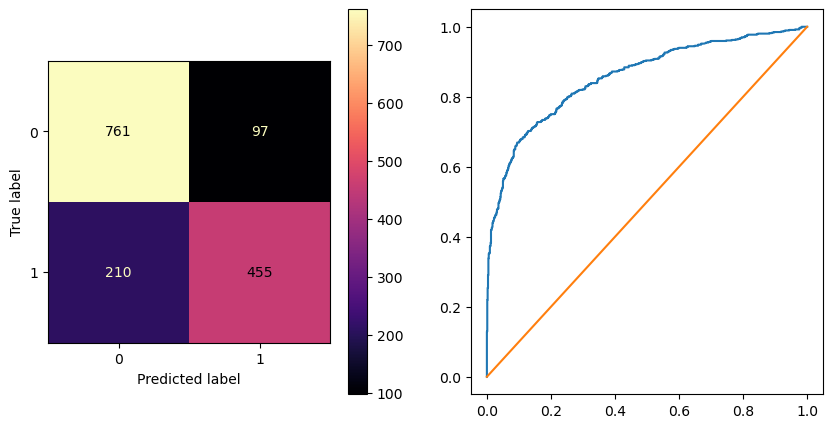

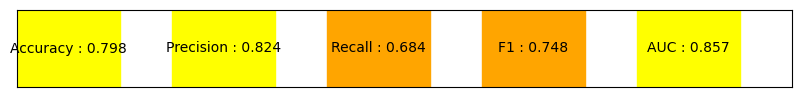

In [45]:
report(TrainValidationWorkflow(
    model=LogisticRegressionModel(C=0.1, solver='liblinear', random_state=random_state_seed),
    input_provider=InputProvider5(),
    df_train=df_train,
    df_validation=df_validation
).get_metrics_calculator())

## hyperparameter tuning of Decision Tree model 
the important hyperparameters to tune for `sklearn.tree.DecisionTreeClassifier` include:
1. `max_depth`
2. `min_samples_leaf`

#### tuning max_depth

In [ ]:
performance = dict()
depths = [1, 3, 5, 10, 15, 20, 50, 100, 200, 500, 1000, None]

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for depth in depths:
        metrics = TrainValidationWorkflow(
            model=DecisionTreeModel(max_depth=depth),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

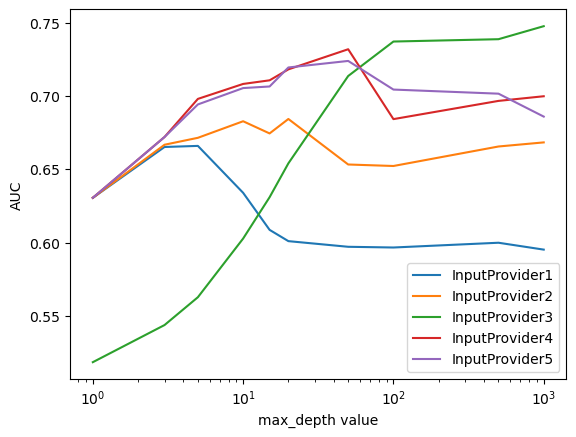

In [33]:
for key, value in performance.items():
    plt.semilogx(depths, value, label=key)
    plt.xlabel('max_depth value')
    plt.ylabel('AUC')
    plt.legend()

the optimum value of max_depth is different for each input_provider (which makes sense)

| input provider number | number of features | optimum value for `max_iter` |
|-----------------------|--------------------|------------------------------|
| 1                     | 7                  | 4                            |
| 2                     | 229                | 20                           |
| 3                     | 15699              | None                         | 
| 4                     | 15707              | 50                           |
| 5                     | 15929              | 50                           |

let's skip this for a second and check max_leaf_nodes

#### tuning min_samples_leaf

In [38]:
performance = dict()
leaf_range = [1, 5, 10, 15, 20, 50, 100, 200]

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for leaf in leaf_range:
        metrics = TrainValidationWorkflow(
            model=DecisionTreeModel(min_samples_leaf=leaf),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

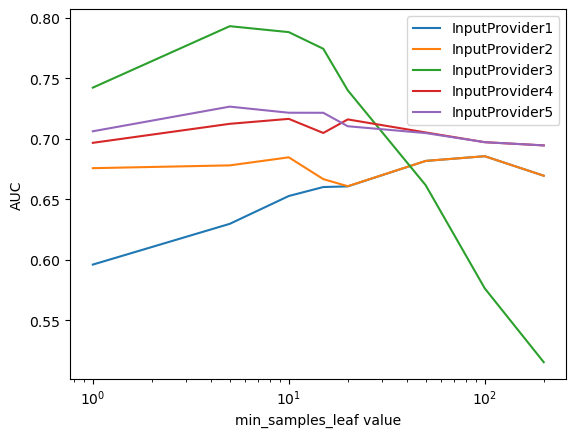

In [40]:
for key, value in performance.items():
    plt.semilogx(leaf_range, value, label=key)
    plt.xlabel('min_samples_leaf value')
    plt.ylabel('AUC')
    plt.legend()

the optimum value of min_samples_leaf is different for each input_provider

| input provider number | number of features | optimum value for `max_iter` |
|-----------------------|--------------------|------------------------------|
| 1                     | 7                  | 100                          |
| 2                     | 229                | 100                          |
| 3                     | 15699              | 5                            | 
| 4                     | 15707              | 10                           |
| 5                     | 15929              | 5                            |

the best AUC was archived using 3rd input provider. so lets this input provider constant and change the min_samples_leaf and max_depth

In [41]:
performance = []
depths = [1, 3, 5, 10, 15, 20, 50, 100, 200, 500, 1000, None]
leaf_range = [1, 5, 10, 15, 20, 50, 100, 200]

for depth in depths:
    perf = []
    for leaf in leaf_range:
        metrics = TrainValidationWorkflow(
            model=DecisionTreeModel(min_samples_leaf=leaf, max_depth=depth),
            input_provider=InputProvider3(),
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        perf.append(metrics.get_auc())
    performance.append(perf)

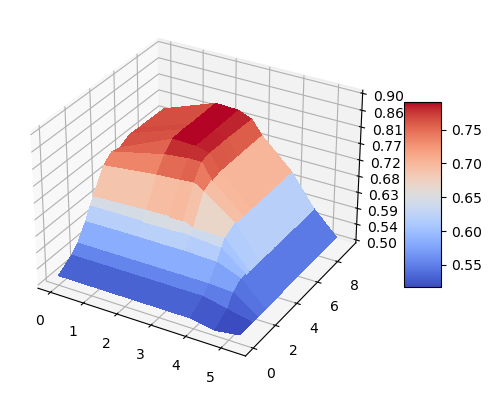

In [80]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
y = [1, 3, 5, 10, 15, 20, 50, 100, 200, 500, 1000, 10000]
x = [1, 5, 10, 15, 20, 50, 100, 200]
x = np.log(x)
y = np.log(y)
x, y = np.meshgrid(x, y)
z = np.array(performance)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.5, 0.9)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [99]:
result = pd.DataFrame(data=performance, columns=leaf_range, index=depths)
row, col = np.where(result == result.max().max())
print(result.max().max())
result

0.794131307289202


,1,5,10,15,20,50,100,200
1.0,0.518383,0.518383,0.518383,0.518383,0.518383,0.518383,0.506543,0.515528
3.0,0.543724,0.543812,0.543812,0.543812,0.543745,0.543729,0.529338,0.515528
5.0,0.562707,0.562941,0.562932,0.562886,0.562838,0.562951,0.558686,0.515528
10.0,0.602862,0.604372,0.603598,0.604283,0.604194,0.600910,0.576541,0.515528
15.0,0.634937,0.636003,0.637390,0.637208,0.634318,0.627125,0.576541,0.515528
20.0,0.652031,0.658598,0.659985,0.659764,0.646776,0.645566,0.576541,0.515528
50.0,0.713640,0.729762,0.733596,0.737392,0.720498,0.661707,0.576541,0.515528
100.0,0.733477,0.766620,0.773710,0.773782,0.732777,0.661707,0.576541,0.515528
200.0,0.727211,0.790675,0.788636,0.780065,0.740208,0.661707,0.576541,0.515528
500.0,0.742528,0.794131,0.788781,0.779086,0.740208,0.661707,0.576541,0.515528


the best hyperparameters are **max_depth=500** and **min_samples_leaf=5**
therefore the best model is:

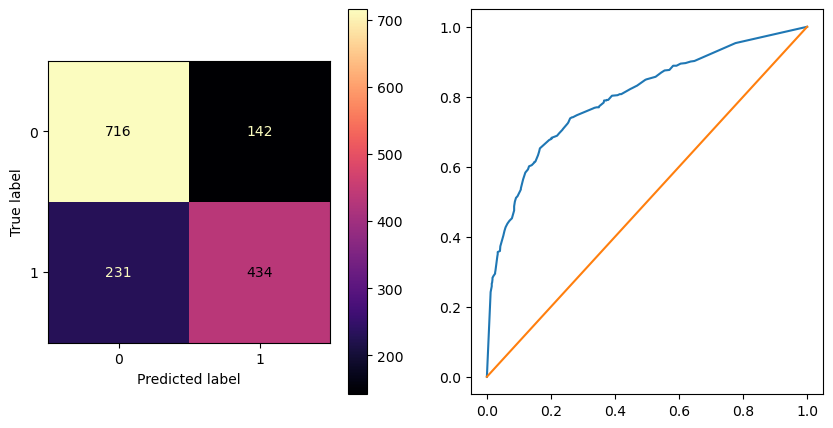

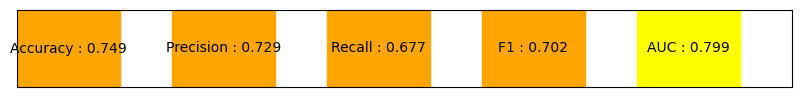

In [100]:
report(TrainValidationWorkflow(
    model=DecisionTreeModel(max_depth=500, min_samples_leaf=5, random_state=random_state_seed),
    input_provider=InputProvider3(),
    df_train=df_train,
    df_validation=df_validation
).get_metrics_calculator())

## hyperparameter tuning of Random forest model 
the important hyperparameters to tune for `sklearn.ensemble.RandomForestClassifier` include:
1. `n_estimators`
2. `max_depth`
3. `max_leaf_nodes`

#### tune n_estimators

In [101]:
performance = dict()
estimators_range = list(range(10, 201, 10))

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for number_of_estimator in estimators_range:
        metrics = TrainValidationWorkflow(
            model=RandomForestModel(n_estimators=number_of_estimator, random_state=random_state_seed),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

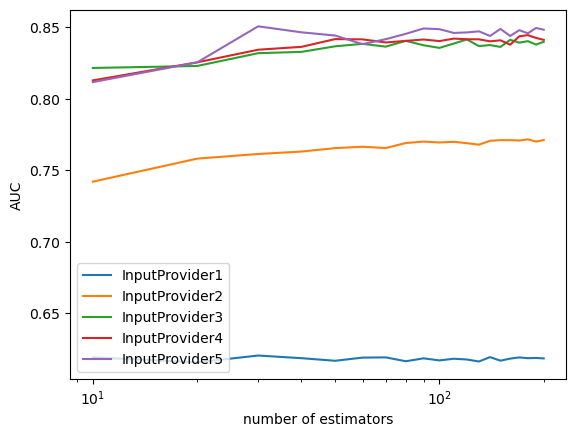

In [103]:
for key, value in performance.items():
    plt.semilogx(estimators_range, value, label=key)
    plt.xlabel('number of estimators')
    plt.ylabel('AUC')
    plt.legend()

we can stick with 30 number of estimator as it will not change the outcome after this.

In [104]:
performance = dict()
depths = [1, 3, 5, 10, 15, 20, 50, 100, 200, 500, 1000, None]

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for depth in depths:
        metrics = TrainValidationWorkflow(
            model=RandomForestModel(max_depth=depth, n_estimators=30, random_state=random_state_seed),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

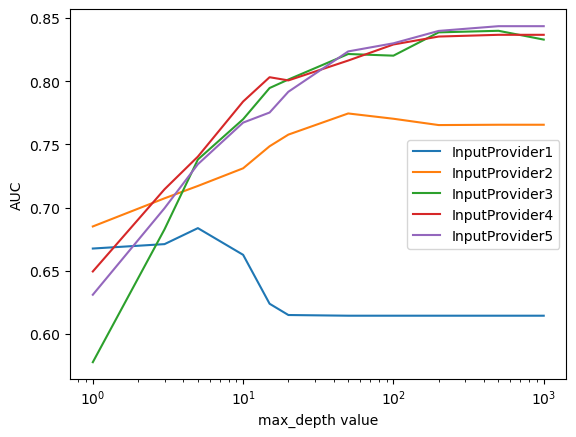

In [105]:
for key, value in performance.items():
    plt.semilogx(depths, value, label=key)
    plt.xlabel('max_depth value')
    plt.ylabel('AUC')
    plt.legend()

again, the behaviour of max_depth for random forest is similar to decision tree

| input provider number | number of features | optimum value for `max_iter` |
|-----------------------|--------------------|------------------------------|
| 1                     | 7                  | 5                            |
| 2                     | 229                | 40                           |
| 3                     | 15699              | None                         | 
| 4                     | 15707              | None                         |
| 5                     | 15929              | None                         |

In [107]:
performance = dict()
leaf_range = [1, 5, 10, 15, 20, 50, 100, 200]

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for leaf in leaf_range:
        metrics = TrainValidationWorkflow(
            model=RandomForestModel(min_samples_leaf=leaf, random_state=random_state_seed),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

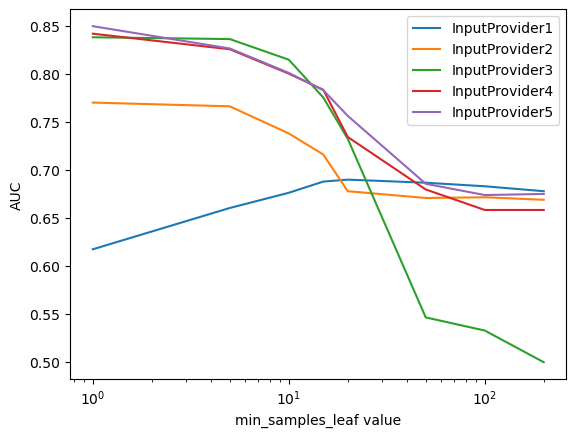

In [109]:
for key, value in performance.items():
    plt.semilogx(leaf_range, value, label=key)
    plt.xlabel('min_samples_leaf value')
    plt.ylabel('AUC')
    plt.legend()

In [126]:
performances = dict()
depths = [20, 50, 100, 200, 500, 1000, 2000, 5000, None]
leaf_range = [1, 2, 5, 8, 10]
input_providers = [InputProvider3(), InputProvider4(), InputProvider5()]

for input_provider in input_providers:
    performance = []
    for depth in depths:
        perf = []
        for leaf in leaf_range:
            metrics = TrainValidationWorkflow(
                model=RandomForestModel(min_samples_leaf=leaf, max_depth=depth, random_state=random_state_seed),
                input_provider=InputProvider3(),
                df_train=df_train,
                df_validation=df_validation
            ).get_metrics_calculator()

            perf.append(metrics.get_auc())
        performance.append(perf)
    performances[input_provider.__class__.__name__] = performance

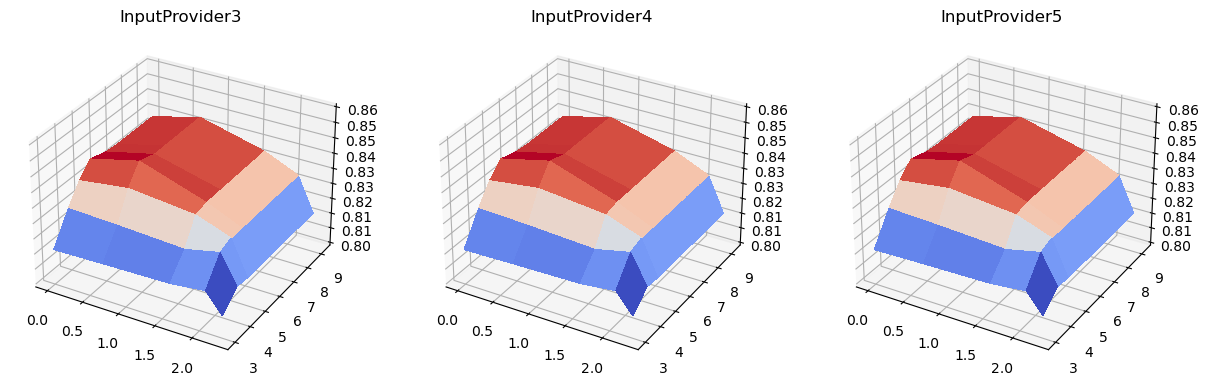

In [129]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, nrows=1, ncols=3, figsize=(15, 5))

# Make data.
y = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
x = [1, 2, 5, 8, 10]
x = np.log(x)
y = np.log(y)
x, y = np.meshgrid(x, y)


def plot_3d(ax, input_provider_name: str):
    z = np.array(performances[input_provider_name])
    ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_zlim(0.8, 0.86)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter('{x:.02f}')
    ax.set_title(input_provider_name)


plot_3d(ax[0], 'InputProvider3')
plot_3d(ax[1], 'InputProvider4')
plot_3d(ax[2], 'InputProvider5')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [135]:
pd.DataFrame(performances['InputProvider4'], columns=leaf_range, index=depths)

,1,2,5,8,10
20.0,0.814235,0.814786,0.815373,0.817048,0.808510
50.0,0.826743,0.825844,0.824237,0.827544,0.815081
100.0,0.834841,0.837666,0.834729,0.829379,0.814449
200.0,0.840365,0.845444,0.835891,0.829379,0.814449
500.0,0.838320,0.843227,0.835891,0.829379,0.814449
1000.0,0.837760,0.843227,0.835891,0.829379,0.814449
2000.0,0.837760,0.843227,0.835891,0.829379,0.814449
5000.0,0.837760,0.843227,0.835891,0.829379,0.814449
NaN,0.837760,0.843227,0.835891,0.829379,0.814449


the best hyperparameters are **max_depth=200** and **min_samples_leaf=2**
therefore the best model is:

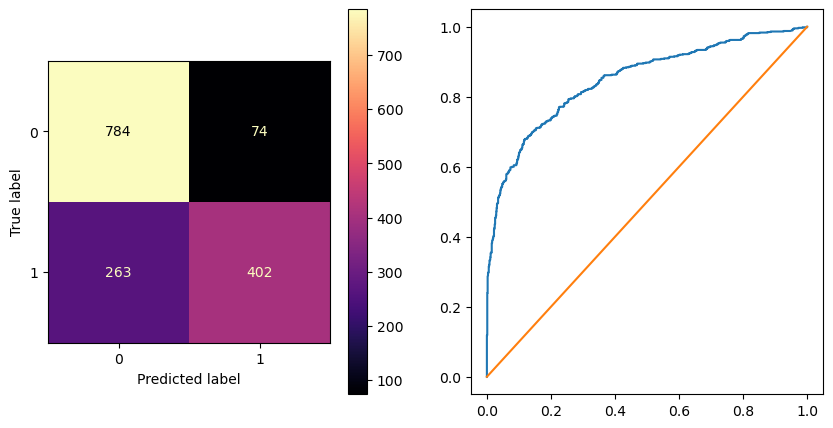

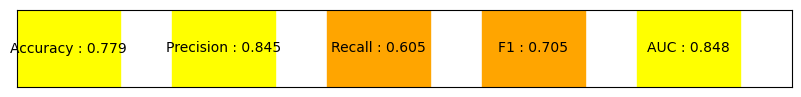

In [138]:
report(TrainValidationWorkflow(
    model=RandomForestModel(max_depth=200, min_samples_leaf=2, n_estimators=30, random_state=random_state_seed),
    input_provider=InputProvider5(),  # InputProvider4() and InputProvider3()
    df_train=df_train,
    df_validation=df_validation
).get_metrics_calculator())

## hyperparameter tuning of XGBoost model 
the important hyperparameters to tune for `xgboost` include:
1. `num_boost_round`
2. `eta`: Learning rate
3. `max_depth`
4. `min_child_weight`

#### tune number of boost rounds

In [ ]:
performance = dict()
boost_rounds = [1, 5, 10, 20, 50, 100, 150, 200, 300, 500]

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for n_boost_round in boost_rounds:
        metrics = TrainValidationWorkflow(
            model=XGBoostModel().set_hyper_parameter('num_boost_round', n_boost_round).set_hyper_parameter('seed',
                                                                                                           random_state_seed),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

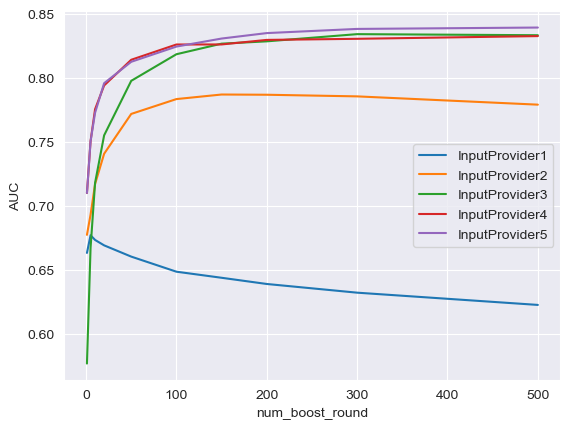

In [22]:
for key, value in performance.items():
    plt.plot(boost_rounds, value, label=key)
    plt.xlabel('num_boost_round')
    plt.ylabel('AUC')
    plt.legend()

In [ ]:
performance = dict()
etas = [0.001, 0.01, 0.1, 1, 10]

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for eta in etas:
        metrics = TrainValidationWorkflow(
            model=XGBoostModel()
            .set_hyper_parameter('eta', eta)
            .set_hyper_parameter('num_boost_round', 200)
            .set_hyper_parameter('seed', random_state_seed),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

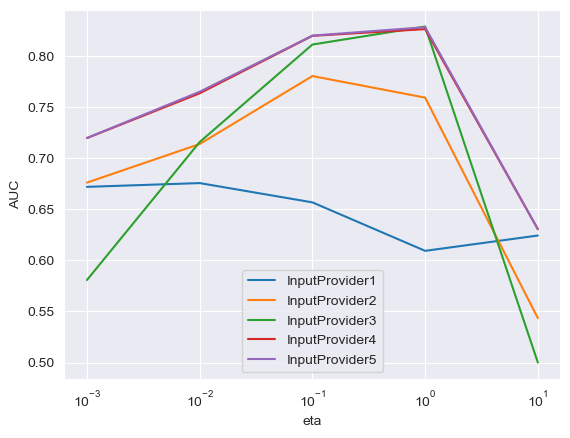

In [24]:
for key, value in performance.items():
    plt.semilogx(etas, value, label=key)
    plt.xlabel('eta')
    plt.ylabel('AUC')
    plt.legend()

In [ ]:
performance = dict()
depths = [1, 3, 5, 10, 15, 20, 50, 100, 200, 500, 1000, None]

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for depth in depths:
        metrics = TrainValidationWorkflow(
            model=XGBoostModel()
            .set_hyper_parameter('eta', 1)
            .set_hyper_parameter('num_boost_round', 200)
            .set_hyper_parameter('seed', random_state_seed)
            .set_hyper_parameter('max_depth', depth),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

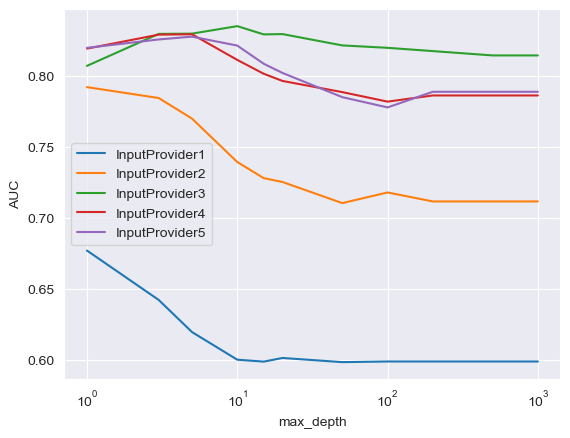

In [6]:
for key, value in performance.items():
    plt.semilogx(depths, value, label=key)
    plt.xlabel('max_depth')
    plt.ylabel('AUC')
    plt.legend()

In [ ]:
performance = dict()
# depths = [3, 5, 10]
leaf_range = [1, 5, 10, 15, 20, 50, 100, 200]

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for child_weight in leaf_range:
        print(f'running model with input {input_provider.__class__.__name__} with depth {depth}')
        metrics = TrainValidationWorkflow(
            model=XGBoostModel()
            .set_hyper_parameter('eta', 1)
            .set_hyper_parameter('num_boost_round', 200)
            .set_hyper_parameter('seed', random_state_seed)
            .set_hyper_parameter('max_depth', 10)
            .set_hyper_parameter('min_child_weight', child_weight),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

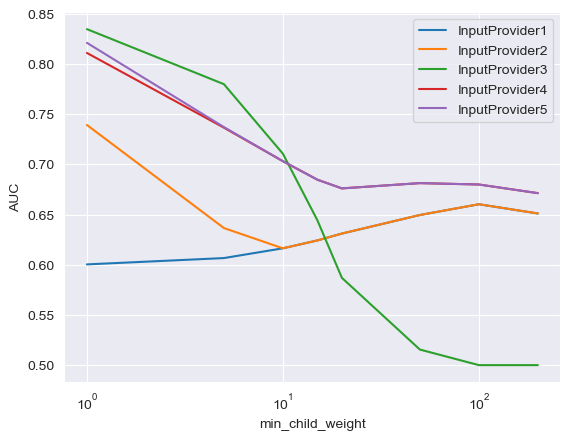

In [9]:
for key, value in performance.items():
    plt.semilogx(leaf_range, value, label=key)
    plt.xlabel('min_child_weight')
    plt.ylabel('AUC')
    plt.legend()

[08:51:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.


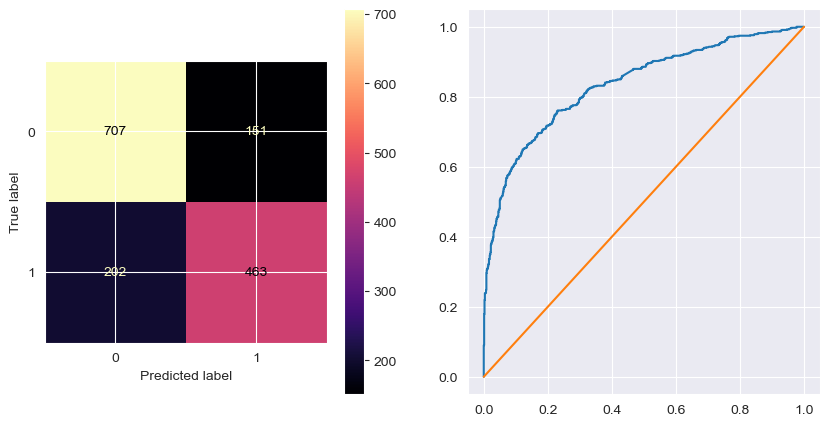

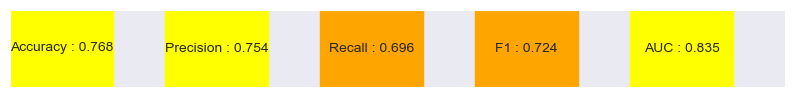

In [12]:
report(TrainValidationWorkflow(
    model=XGBoostModel()
    .set_hyper_parameter('eta', 1)
    .set_hyper_parameter('num_boost_round', 200)
    .set_hyper_parameter('seed', random_state_seed)
    .set_hyper_parameter('max_depth', 10),
    input_provider=InputProvider3(),
    df_train=df_train,
    df_validation=df_validation
).get_metrics_calculator())

## Model selection

In [13]:
best_models_so_far = [
    {
        'model': LogisticRegressionModel(C=0.1, solver='liblinear', random_state=random_state_seed),
        'input_provider': InputProvider5(),
    },
    {
        'model': DecisionTreeModel(max_depth=500, min_samples_leaf=5, random_state=random_state_seed),
        'input_provider': InputProvider3(),
    },
    {
        'model': RandomForestModel(max_depth=200, min_samples_leaf=2, n_estimators=30, random_state=random_state_seed),
        'input_provider': InputProvider3(),
    },
    {
        'model': RandomForestModel(max_depth=200, min_samples_leaf=2, n_estimators=30, random_state=random_state_seed),
        'input_provider': InputProvider4(),
    },
    {
        'model': RandomForestModel(max_depth=200, min_samples_leaf=2, n_estimators=30, random_state=random_state_seed),
        'input_provider': InputProvider5(),
    },
    {
        'model': XGBoostModel()
        .set_hyper_parameter('eta', 1)
        .set_hyper_parameter('num_boost_round', 200)
        .set_hyper_parameter('seed', random_state_seed)
        .set_hyper_parameter('max_depth', 10),
        'input_provider': InputProvider3()
    }
]

In [14]:
performances = []
for model_data in best_models_so_far:
    model = model_data['model']
    input_provider = model_data['input_provider']
    metrics = TrainValidationWorkflow(model=model,
                                      input_provider=input_provider,
                                      df_train=df_train,
                                      df_validation=df_validation).get_metrics_calculator()
    performances.append({
        'model': model.__class__.__name__,
        'input_provider': input_provider.__class__.__name__,
        'accuracy': metrics.get_accuracy(),
        'precision': metrics.get_precision(),
        'recall': metrics.get_recall(),
        'f1': metrics.get_f1(),
        'auc': metrics.get_auc(),
    })

[08:54:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.


In [15]:
result = pd.DataFrame(performances)
result

,model,input_provider,accuracy,precision,recall,f1,auc
0,LogisticRegressionModel,InputProvider5,0.798424,0.824275,0.684211,0.747740,0.856503
1,DecisionTreeModel,InputProvider3,0.749179,0.729335,0.676692,0.702028,0.798636
2,RandomForestModel,InputProvider3,0.774787,0.818182,0.622556,0.707088,0.844112
3,RandomForestModel,InputProvider4,0.778070,0.869074,0.578947,0.694946,0.839612
4,RandomForestModel,InputProvider5,0.778726,0.844538,0.604511,0.704645,0.848470
5,XGBoostModel,InputProvider3,0.768221,0.754072,0.696241,0.724003,0.834932


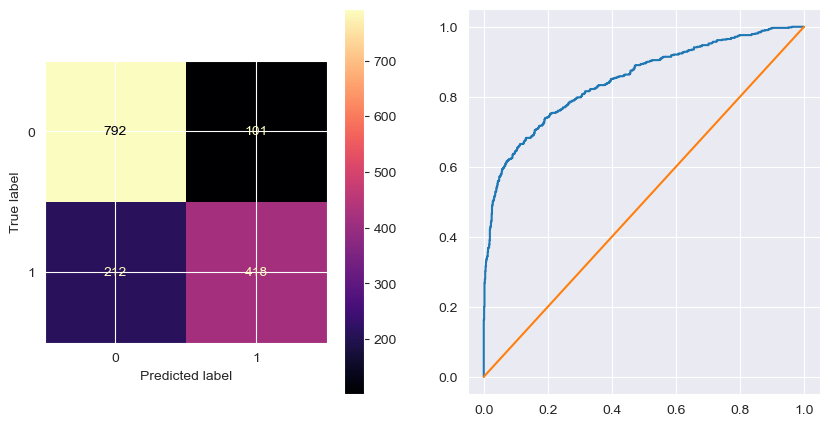

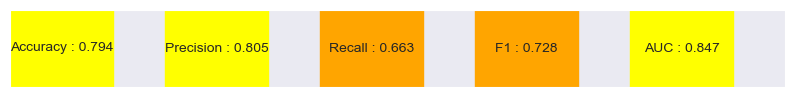

In [19]:
report(TrainValidationWorkflow(
    model=LogisticRegressionModel(C=0.1, solver='liblinear', random_state=random_state_seed),
    input_provider=InputProvider5(),
    df_train=df_train_validation,
    df_validation=df_test
).get_metrics_calculator())

In [5]:
flow = TrainValidationWorkflow(
    model=LogisticRegressionModel(C=0.1, solver='liblinear'),
    input_provider=InputProvider5(),
    df_train=df_train_validation
)

final_model, input_provider = flow.get_model_and_input_provider()

In [6]:
with open('model.bin', 'wb') as f_out:
    pickle.dump(final_model, f_out)

with open('input_provider.bin', 'wb') as f_out:
    pickle.dump(input_provider, f_out)

In [5]:
class PreTrainedModel(object):
    def __init__(self):
        self.model: ModelInterface = self.load_model()
        self.input_provider: InputProvider5 = self.load_input_provider()

    def load_model(self) -> ModelInterface:
        with open('model.bin', 'rb') as f_in:
            model = pickle.load(f_in)
        return model

    def load_input_provider(self) -> InputProvider5:
        with open('input_provider.bin', 'rb') as f_in:
            input_provider = pickle.load(f_in)
        return input_provider

    def get_prediction_probability(self, data: dict) -> float:
        df = pd.DataFrame(data, index=[0])
        x = self.input_provider.get_input(df)
        return self.model.predict_proba(x)[:, 1][0]

In [7]:
PreTrainedModel().get_prediction_probability(
    {
        "keyword": "ablaze",
        "location": "USA",
        "text": "INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA"
    }
)

0.5057735645561993